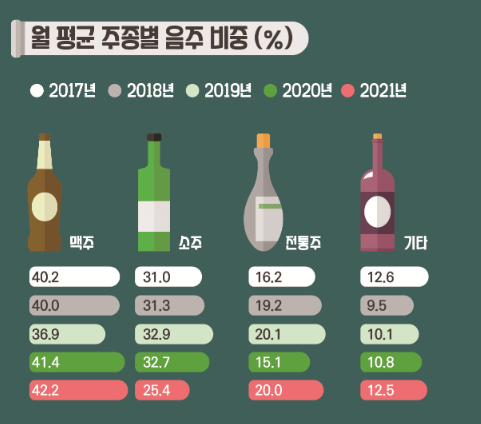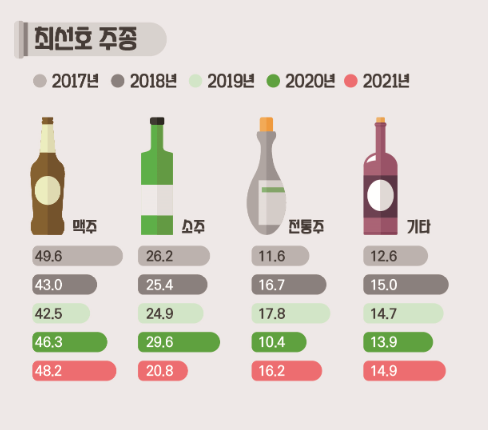

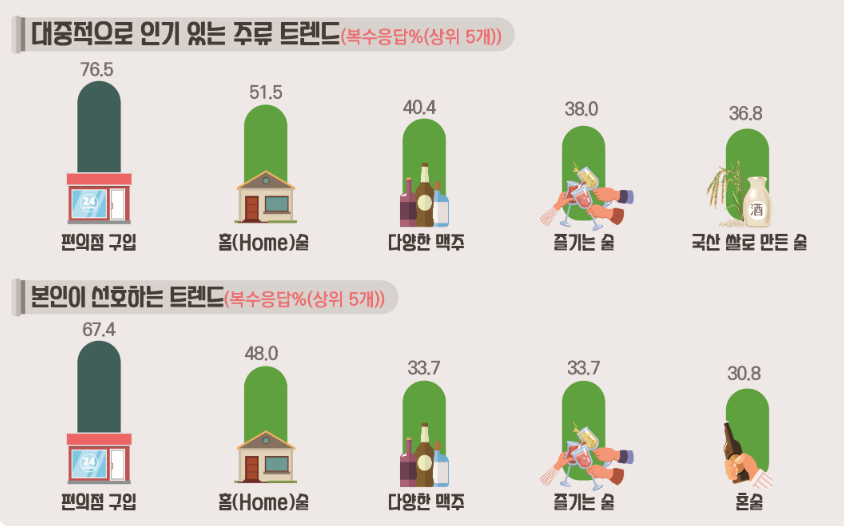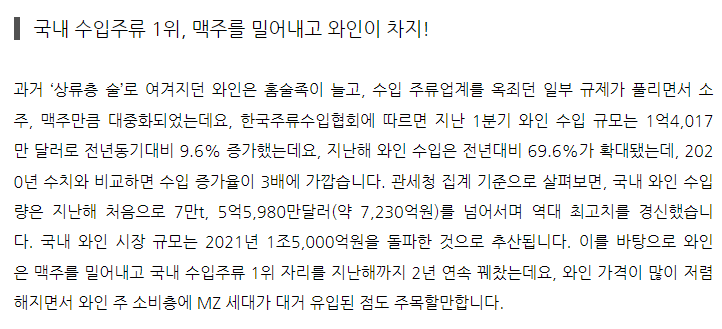

# 와인 추천 시스템

In [46]:
!pip install -U nbformat

  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.1.3
    Uninstalling nbformat-5.1.3:
      Successfully uninstalled nbformat-5.1.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.


## 와인 데이터 가져오기

In [1]:
import requests
import pandas as pd
import time
import random

### 와인 색인 후 리스트 가져오기
vivino에서

 * **포트투갈(pt), 스페인(ex), 프랑스(fr), 오스트레일리아(nf), 미국(us), 이테리(it) 컨트리 코드로 색인**

* **red wine**

* **인기순으로**

* **3.0점 이상**

으로 색인 후 페이지를 넘겨가며 해당 와인 정보 가져오기.


In [ ]:
# user ID 추가
wine = pd.DataFrame(columns=["Winery", "Year", "Wine ID", "Wine","Winefullname(eng)", "Rating", "num_review",\
                "image",'name2', 'mostusedgrapes', 'acidity', 'fizziness', 'intensity', 'sweetness', \
                'tannin', 'user_structure_count', 'calculated_structure_count', 'flavor', 'description', 'food', \
                'grapes','region','country', 'url'])
pagelist=[]
errpage=[]
for i in range(1,100):
    nCount = 0
    nMaxCount = 2
    while nCount < nMaxCount:
        # try, except를 통해 와인리스트 페이지 불러오기 실패시 2번더 시도 후 넘기기
          try:
            r = requests.get(
                "https://www.vivino.com/api/explore/explore",
                params={
                        "country_code": "US",
                        "country_codes[]": ["pt", "es", "fr", "nf", "us", "it"],  # pt포트투갈 es 스페인 fr 프랑스 nf오스트레일리아 it이테리
                        "wine_type_ids[]": "1",
                        "sort":"popular",
                        "order": "desc",
                        "rating_range_min": "3",
                        "currency_code": "DOLLER",
                        "page": i,

                },
                headers={
                    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:66.0) Gecko/20100101 Firefox/66.0"
                },
            )

            results = [
                (
                    t["vintage"]["wine"]["winery"]["name"],
                    t["vintage"]["year"],
                    t["vintage"]["wine"]["id"],
                    f'{t["vintage"]["wine"]["name"]} {t["vintage"]["year"]}',
                    t["vintage"]["seo_name"],#Wine(eng) 영어이름 위에 이름은 불어등이 불러와짐. 
                    t["vintage"]["statistics"]["ratings_average"],
                    t["vintage"]["statistics"]["ratings_count"],
                    t["vintage"]["image"]["variations"],#["bottle_large"], 추후에 뽑아서 자르는 것 필요
                    t["vintage"]["wine"]['seo_name'], 
                    t["vintage"]["wine"]['region']['country']['most_used_grapes'],#['name']을 추출 필요
                    t["vintage"]["wine"]['taste']['structure']['acidity'],
                    t["vintage"]["wine"]['taste']['structure']['fizziness'],
                    t["vintage"]["wine"]['taste']['structure']['intensity'],
                    t["vintage"]["wine"]['taste']['structure']['sweetness'],
                    t["vintage"]["wine"]['taste']['structure']['tannin'],
                    t["vintage"]["wine"]['taste']['structure']['user_structure_count'],
                    t["vintage"]["wine"]['taste']['structure']['calculated_structure_count'],
                    t["vintage"]["wine"]['taste']['flavor'], # 추후 자르기 필요
                    t["vintage"]["wine"]['style']['description'],
                    t["vintage"]["wine"]['style']['food'],#['name']  [안에 내용] 추출 필요
                    t["vintage"]["wine"]['style']['grapes'], # ['name'] 추출 필요
                    t["vintage"]["wine"]['style']['region'],#['name'] 지역정보가 없는 애들이 있어서 name을 찾지 못하는 경우 발생,
                    t["vintage"]["wine"]['style']['region'],#['country']['name'], 같은 문제 발생 
                    t["price"]["url"],
                )
                for t in r.json()["explore_vintage"]["matches"]
            ]
            dataframe = pd.DataFrame(
                results,
                columns=["Winery", "Year", "Wine ID", "Wine","Winefullname(eng)", "Rating", "num_review",\
                        "image",'name2', 'mostusedgrapes', 'acidity', 'fizziness', 'intensity', 'sweetness', \
                        'tannin', 'user_structure_count', 'calculated_structure_count', 'flavor', 'description', 'food', \
                        'grapes','region','country', 'url'],
            )
            wine=pd.concat([wine, dataframe])
            print(f"{i}번째 페이지")
            time.sleep( random.uniform(2,6) )
            nCount =2
          except:
            print(f"{i}번째 페이지 에러")
            nCount += 1
            errpage.append(i)

### 리뷰 가져오기
와인 칼럼
```python
["Winery", "Year", "Wine ID", "Wine","Winefullname(eng)", 
 "Rating", "num_review", "image",'name2', 'mostusedgrapes', 
 'acidity', 'fizziness', 'intensity', 'sweetness', 'tannin', 
 'user_structure_count', 'calculated_structure_count', 'flavor', 
 'description', 'food',  'grapes','region','country', 'url']
```
  
**크롤링한 와인 정보에서 ID와 Year를 기준으로 리뷰 크롤링**  
  
**해당 정보 가져올 때 리뷰별로 language정보가 있어 en만 가져옴.**  
  
    
와인 리뷰 칼럼  
```python
["Year", "Wine ID", "User Rating", "Note", "CreatedAt","user_id"]
```

In [ ]:
# 와인 리뷰 요청 함수
def get_wine_data(wine_id, year, page):
    headers = {
        "User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.69 Safari/537.36",
        #"User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0",
    }

    api_url = "https://www.vivino.com/api/wines/{id}/reviews?per_page=50&year={year}&page={page}"  # <-- increased the number of reviews to 9999

    data = requests.get(
        api_url.format(id=wine_id, year=year, page=page), headers=headers
    ).json()

    return data
ratings=[]

In [ ]:
# 와인 리스트를 통해 리뷰 요청 
checknote=0
for _, row in wine[1550:].iterrows():
#for _, row in wine[89:101].iterrows():
    page = 1
    while True:
        print(
            f'Getting info about wine {row["Wine ID"]}-{row["Year"]} Page {page}'
        )

        d = get_wine_data(row["Wine ID"], row["Year"], page)
        

        if not d["reviews"]:
            break

        for r in d["reviews"]:
            if r["language"] != "en": # <-- 영어리뷰만 가져오기
                continue
                
            ratings.append(
                [
                    row["Year"],
                    row["Wine ID"],
                    r["rating"],
                    r["note"],
                    r["created_at"],
                    r['user']['id'],
                ]
            )
            

        page += 1
        checknote+=1
        #time.sleep( random.uniform(0,2) )
        if checknote == 2000:
            time.sleep( 60 )
            checknote=1
# 리뷰 데이터 데이터프레임
ratings = pd.DataFrame(
    ratings, columns=["Year", "Wine ID", "User Rating", "Note", "CreatedAt","user_id"]
)
# 리뷰 데이터 및 와인데이터 합치기
df_out_all = ratings.merge(wine)

## 와인 데이터 전처리

### 와인 데이터 합치기

In [2]:
rating1 = pd.read_csv('./data/ratings_all_to_1099.csv')
rating2 = pd.read_csv('./data/ratings_all_at_1100.csv')
rating3 = pd.read_csv('./data/ratings_all_at_1250.csv')
rating4 = pd.read_csv('./data/ratings_af_1551_1704.csv')
rating5 = pd.read_csv('./data/ratings_af_1705_2000.csv')

C:\Users\tjtmd\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
rate_final=pd.DataFrame(columns=["Year", "Wine ID", "User Rating", "Note", "CreatedAt","user_id"])
for i in [rating1, rating2, rating3, rating4, rating5]:
    rate_final=pd.concat([rate_final, i])
rate_final

,Year,Wine ID,User Rating,Note,CreatedAt,user_id
0,2018.0,82025,5.0,"What can you say? Really, really, good. So sm...",2021-06-13T00:57:55.000Z,2644975
1,2018.0,82025,4.5,Wally’s has Screaming Eagle ‘18 by the glass f...,2021-10-26T04:40:45.000Z,52282875
2,2018.0,82025,5.0,Most incredible wine experience of my life…,2022-03-19T04:35:28.000Z,2575166
3,2018.0,82025,5.0,Looooved this so dang much!,2014-08-31T04:41:09.000Z,2881855
4,2018.0,82025,5.0,Big question mark ... maybe not tasted in the ...,2018-12-10T20:37:27.000Z,1263116
...,...,...,...,...,...,...
282763,1996,22685,5.0,Greaaaaat boho club,2022-08-01T21:32:55.000Z,30350575
282764,1996,22685,5.0,super! aromatic and delicous. and red ;-)) \n,2022-01-16T18:02:58.000Z,46163989
282765,1996,22685,5.0,"Vivino thought it was 2012, But it is 2004. Gr...",2019-01-05T19:40:40.000Z,27265753
282766,1996,22685,5.0,blackcurrant cedar cedar,2020-11-10T11:21:05.000Z,46566253


### 와인 데이터 불러오기 

In [4]:
import pandas as pd
import pickle
import os
import ast
import pandas as pd

In [5]:
#data = pd.read_pickle('./data/df_out.pkl') # pt
data = pd.read_csv('./data/wine_all.csv')
data

,Winery,Year,Wine ID,Wine,Winefullname(eng),Rating,num_review,image,name2,mostusedgrapes,...,tannin,user_structure_count,calculated_structure_count,flavor,description,food,grapes,region,country,url
0,Screaming Eagle,2018,82025,Cabernet Sauvignon 2018,screaming-eagle-cabernet-sauvignon-2018,4.9,44,{'bottle_large': '//images.vivino.com/thumbs/Z...,cabernet-sauvignon,"[{'id': 2, 'name': 'Cabernet Sauvignon', 'seo_...",...,3.533957,169,194,"[{'group': 'oak', 'stats': {'count': 115, 'sco...",NaN,"[{'id': 4, 'name': 'Beef', 'background_image':...","[{'id': 2, 'name': 'Cabernet Sauvignon', 'seo_...","{'id': 25, 'name': 'Napa Valley', 'name_en': '...","{'id': 25, 'name': 'Napa Valley', 'name_en': '...",https://www.gilturners.com/wine/2018-screaming...
1,Schrader,2015,3151741,Cabernet Sauvignon CCS Beckstoffer To Kalon Vi...,schrader-cellars-cabernet-sauvignon-ccs-beckst...,4.9,33,{'bottle_large': '//images.vivino.com/thumbs/_...,cabernet-sauvignon-ccs-beckstoffer-to-kalon-vi...,"[{'id': 2, 'name': 'Cabernet Sauvignon', 'seo_...",...,3.224029,98,72,"[{'group': 'black_fruit', 'stats': {'count': 5...",NaN,"[{'id': 4, 'name': 'Beef', 'background_image':...","[{'id': 2, 'name': 'Cabernet Sauvignon', 'seo_...","{'id': 25, 'name': 'Napa Valley', 'name_en': '...","{'id': 25, 'name': 'Napa Valley', 'name_en': '...",https://tarzanawineandspirits.com/
2,Vega Sicilia,2009,77137,Unico 2009,vega-sicilia-unico-2009,4.8,1955,{'bottle_large': '//images.vivino.com/thumbs/S...,unico,"[{'id': 19, 'name': 'Tempranillo', 'seo_name':...",...,3.415408,2343,1509,"[{'group': 'oak', 'stats': {'count': 1285, 'sc...","Rioja may be the most famous region in Spain, ...","[{'id': 4, 'name': 'Beef', 'background_image':...","[{'id': 19, 'name': 'Tempranillo', 'seo_name':...","{'id': 405, 'name': 'Ribera del Duero', 'name_...","{'id': 405, 'name': 'Ribera del Duero', 'name_...",https://winecellarage.com/wine/2009-vega-sicil...
3,Château Latour,1982,1655970,Grand Vin Pauillac (Premier Grand Cru Classé) ...,fr-chateau-latour-grand-vin-pauillac-premier-g...,4.8,1319,{'bottle_large': '//images.vivino.com/thumbs/4...,grand-vin-pauillac-premier-grand-cru-classe,"[{'id': 14, 'name': 'Pinot Noir', 'seo_name': ...",...,4.139232,1258,1891,"[{'group': 'oak', 'stats': {'count': 1497, 'sc...",Bordeaux Pauillac wines are rich and concentra...,"[{'id': 4, 'name': 'Beef', 'background_image':...","[{'id': 2, 'name': 'Cabernet Sauvignon', 'seo_...","{'id': 383, 'name': 'Bordeaux', 'name_en': '',...","{'id': 383, 'name': 'Bordeaux', 'name_en': '',...",https://wineconsigners.com/collections/all/pro...
4,Château Margaux,2000,1127795,Château Margaux (Premier Grand Cru Classé) 2000,chateau-margaux-chateau-margaux-premier-grand-...,4.8,1265,{'bottle_large': '//images.vivino.com/thumbs/D...,chateau-margaux-premier-grand-cru-classe,"[{'id': 14, 'name': 'Pinot Noir', 'seo_name': ...",...,3.814632,977,2276,"[{'group': 'oak', 'stats': {'count': 1595, 'sc...",Bordeaux Margaux wines tend to be deep ruby in...,"[{'id': 4, 'name': 'Beef', 'background_image':...","[{'id': 2, 'name': 'Cabernet Sauvignon', 'seo_...","{'id': 383, 'name': 'Bordeaux', 'name_en': '',...","{'id': 383, 'name': 'Bordeaux', 'name_en': '',...",https://winecellarage.com/wine/2000-chateau-ma...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,Château Margaux,2004,6020,Pavillon Rouge du Château Margaux 2004,chateau-margaux-pavillon-rouge-du-chateau-marg...,4.4,1111,{'bottle_large': '//images.vivino.com/thumbs/I...,pavillon-rouge-du-chateau-margaux,"[{'id': 14, 'name': 'Pinot Noir', 'seo_name': ...",...,3.726111,375,762,"[{'group': 'oak', 'stats': {'count': 534, 'sco...",Bordeaux Margaux wines tend to be deep ruby in...,"[{'id': 4, 'name': 'Beef', 'background_image':...","[{'id': 2, 'name': 'Cabernet Sauvignon', 'seo_...","{'id': 383, 'name': 'Bordeaux', 'name_en': '',...","{'id': 383, 'name': 'Bordeaux', 'name_en': '',...",https://winecellarage.com/wine/2004-pavillon-r...
2221,Latium Morin

In [6]:
# 열 삭제
data = data.drop(['mostusedgrapes'],axis=1)

In [7]:
data.head()

,Winery,Year,Wine ID,Wine,Winefullname(eng),Rating,num_review,image,name2,acidity,...,tannin,user_structure_count,calculated_structure_count,flavor,description,food,grapes,region,country,url
0,Screaming Eagle,2018,82025,Cabernet Sauvignon 2018,screaming-eagle-cabernet-sauvignon-2018,4.9,44,{'bottle_large': '//images.vivino.com/thumbs/Z...,cabernet-sauvignon,3.360757,...,3.533957,169,194,"[{'group': 'oak', 'stats': {'count': 115, 'sco...",NaN,"[{'id': 4, 'name': 'Beef', 'background_image':...","[{'id': 2, 'name': 'Cabernet Sauvignon', 'seo_...","{'id': 25, 'name': 'Napa Valley', 'name_en': '...","{'id': 25, 'name': 'Napa Valley', 'name_en': '...",https://www.gilturners.com/wine/2018-screaming...
1,Schrader,2015,3151741,Cabernet Sauvignon CCS Beckstoffer To Kalon Vi...,schrader-cellars-cabernet-sauvignon-ccs-beckst...,4.9,33,{'bottle_large': '//images.vivino.com/thumbs/_...,cabernet-sauvignon-ccs-beckstoffer-to-kalon-vi...,3.334318,...,3.224029,98,72,"[{'group': 'black_fruit', 'stats': {'count': 5...",NaN,"[{'id': 4, 'name': 'Beef', 'background_image':...","[{'id': 2, 'name': 'Cabernet Sauvignon', 'seo_...","{'id': 25, 'name': 'Napa Valley', 'name_en': '...","{'id': 25, 'name': 'Napa Valley', 'name_en': '...",https://tarzanawineandspirits.com/
2,Vega Sicilia,2009,77137,Unico 2009,vega-sicilia-unico-2009,4.8,1955,{'bottle_large': '//images.vivino.com/thumbs/S...,unico,3.700484,...,3.415408,2343,1509,"[{'group': 'oak', 'stats': {'count': 1285, 'sc...","Rioja may be the most famous region in Spain, ...","[{'id': 4, 'name': 'Beef', 'background_image':...","[{'id': 19, 'name': 'Tempranillo', 'seo_name':...","{'id': 405, 'name': 'Ribera del Duero', 'name_...","{'id': 405, 'name': 'Ribera del Duero', 'name_...",https://winecellarage.com/wine/2009-vega-sicil...
3,Château Latour,1982,1655970,Grand Vin Pauillac (Premier Grand Cru Classé) ...,fr-chateau-latour-grand-vin-pauillac-premier-g...,4.8,1319,{'bottle_large': '//images.vivino.com/thumbs/4...,grand-vin-pauillac-premier-grand-cru-classe,4.128739,...,4.139232,1258,1891,"[{'group': 'oak', 'stats': {'count': 1497, 'sc...",Bordeaux Pauillac wines are rich and concentra...,"[{'id': 4, 'name': 'Beef', 'background_image':...","[{'id': 2, 'name': 'Cabernet Sauvignon', 'seo_...","{'id': 383, 'name': 'Bordeaux', 'name_en': '',...","{'id': 383, 'name': 'Bordeaux', 'name_en': '',...",https://wineconsigners.com/collections/all/pro...
4,Château Margaux,2000,1127795,Château Margaux (Premier Grand Cru Classé) 2000,chateau-margaux-chateau-margaux-premier-grand-...,4.8,1265,{'bottle_large': '//images.vivino.com/thumbs/D...,chateau-margaux-premier-grand-cru-classe,4.164936,...,3.814632,977,2276,"[{'group': 'oak', 'stats': {'count': 1595, 'sc...",Bordeaux Margaux wines tend to be deep ruby in...,"[{'id': 4, 'name': 'Beef', 'background_image':...","[{'id': 2, 'name': 'Cabernet Sauvignon', 'seo_...","{'id': 383, 'name': 'Bordeaux', 'name_en': '',...","{'id': 383, 'name': 'Bordeaux', 'name_en': '',...",https://winecellarage.com/wine/2000-chateau-ma...


In [8]:
data.columns

Index(['Winery', 'Year', 'Wine ID', 'Wine', 'Winefullname(eng)', 'Rating',
       'num_review', 'image', 'name2', 'acidity', 'fizziness', 'intensity',
       'sweetness', 'tannin', 'user_structure_count',
       'calculated_structure_count', 'flavor', 'description', 'food', 'grapes',
       'region', 'country', 'url'],
      dtype='object')

In [104]:
# image, flavor, food, 

### image

딕셔너리 형태로 불러져 있어 해당 내용중 우리에게 필요한 **large**항목 추출

In [9]:
# image
image = data['image']
image

0       {'bottle_large': '//images.vivino.com/thumbs/Z...
1       {'bottle_large': '//images.vivino.com/thumbs/_...
2       {'bottle_large': '//images.vivino.com/thumbs/S...
3       {'bottle_large': '//images.vivino.com/thumbs/4...
4       {'bottle_large': '//images.vivino.com/thumbs/D...
                              ...                        
2220    {'bottle_large': '//images.vivino.com/thumbs/I...
2221    {'bottle_large': '//images.vivino.com/thumbs/C...
2222    {'bottle_large': '//images.vivino.com/thumbs/1...
2223    {'bottle_large': '//images.vivino.com/thumbs/O...
2224    {'bottle_large': '//images.vivino.com/thumbs/F...
Name: image, Length: 2225, dtype: object

In [10]:
type(image[0])

str

In [11]:
image[0][0]

'{'

In [12]:
# 위위 행 dict로 나올경우
# for i in range(len(image)):
# #     a = ast.literal_eval(image[i])
#     print(image[i]['large'])
#     data['image'][i] = image[i]['large']

# 위위 행 str로 나올경우
for i in range(len(image)):
    a = ast.literal_eval(image[i])
    
    data['image'][i] = a['large']

C:\Users\tjtmd\AppData\Local\Temp/ipykernel_16072/1007624918.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['image'][i] = a['large']


In [13]:
data['image']

0       //images.vivino.com/thumbs/Z92v0bohTBaVUVPNjiX...
1       //images.vivino.com/thumbs/_jt3dPPrSZKfVmV6J8Y...
2       //images.vivino.com/thumbs/SCnpJk_ySUe6XS3U-lF...
3       //images.vivino.com/thumbs/4RHhCzeQTsCeyCScxO0...
4       //images.vivino.com/thumbs/DygMHm5zSi2qXX6I0Hk...
                              ...                        
2220    //images.vivino.com/thumbs/IKYGOPzNQgW34bK7oGA...
2221    //images.vivino.com/thumbs/CSceRkhCSKmFWYCSQVW...
2222    //images.vivino.com/thumbs/1YXUHwcmS7i4jvfW2oO...
2223    //images.vivino.com/thumbs/O4kITUXPQQ2CeYjKELV...
2224    //images.vivino.com/thumbs/FvLdztxrRXOZxU1jfVo...
Name: image, Length: 2225, dtype: object

### food

[{}, {}, {}...] ==> 리스트 안 딕셔너리 형태를 띄고 있었음.

해당 내용중 상위 4개의 음식을 뽑아옴

In [14]:
# food
food = data['food']
food[500]

"[{'id': 4, 'name': 'Beef', 'background_image': {'location': '//images.vivino.com/backgrounds/foods/4_beef.png', 'variations': {'small': '//images.vivino.com/backgrounds/foods/thumbs/4_beef_932x810.png'}}, 'seo_name': 'beef'}, {'id': 8, 'name': 'Lamb', 'background_image': {'location': '//images.vivino.com/backgrounds/foods/8_lamb.png', 'variations': {'small': '//images.vivino.com/backgrounds/foods/thumbs/8_lamb_932x810.png'}}, 'seo_name': 'lamb'}, {'id': 11, 'name': 'Game (deer, venison)', 'background_image': {'location': '//images.vivino.com/backgrounds/foods/11_venison.png', 'variations': {'small': '//images.vivino.com/backgrounds/foods/thumbs/11_venison_932x810.png'}}, 'seo_name': 'game'}, {'id': 17, 'name': 'Mature and hard cheese', 'background_image': {'location': '//images.vivino.com/backgrounds/foods/17_hardcheese.png', 'variations': {'small': '//images.vivino.com/backgrounds/foods/thumbs/17_hardcheese_932x810.png'}}, 'seo_name': None}, {'id': 20, 'name': 'Poultry', 'background_

In [15]:
type(food[0])

str

#### list 일 경우

In [54]:
# type(food[0][0])

str

In [55]:
# food[0][0]

'Beef'

In [14]:
# food[0]# 첫행

[{'id': 4,
  'name': 'Rundvlees',
  'background_image': {'location': '//images.vivino.com/backgrounds/foods/4_beef.png',
   'variations': {'small': '//images.vivino.com/backgrounds/foods/thumbs/4_beef_932x810.png'}},
  'seo_name': 'beef'},
 {'id': 5,
  'name': 'Pasta',
  'background_image': {'location': '//images.vivino.com/backgrounds/foods/5_pasta.png',
   'variations': {'small': '//images.vivino.com/backgrounds/foods/thumbs/5_pasta_932x810.png'}},
  'seo_name': None},
 {'id': 9,
  'name': 'Kalfsvlees',
  'background_image': {'location': '//images.vivino.com/backgrounds/foods/9_veal.png',
   'variations': {'small': '//images.vivino.com/backgrounds/foods/thumbs/9_veal_932x810.png'}},
  'seo_name': 'veal'},
 {'id': 20,
  'name': 'Gevogelte',
  'background_image': {'location': '//images.vivino.com/backgrounds/foods/20_chicken.png',
   'variations': {'small': '//images.vivino.com/backgrounds/foods/thumbs/20_chicken_932x810.png'}},
  'seo_name': 'poultry'}]

In [15]:
# food[0][0] # 첫행의 첫번째 맛들어있는 dict

{'id': 4,
 'name': 'Rundvlees',
 'background_image': {'location': '//images.vivino.com/backgrounds/foods/4_beef.png',
  'variations': {'small': '//images.vivino.com/backgrounds/foods/thumbs/4_beef_932x810.png'}},
 'seo_name': 'beef'}

In [16]:
# food[0][0]['name']

'Rundvlees'

In [17]:
# type(food[0]) 가 리스트 형태일 경우
# for i in range(4):
#     food[0][i]['name']
#     print(food[0][i]['name'])
    

Rundvlees
Pasta
Kalfsvlees
Gevogelte


In [18]:
# type(food[0]) 가 리스트 형태일 경우
# for j in range(len(food)):    
#     temp=[]
#     for i in range(4):
#         temp.append(food[j][i]['name'])
#         print(food[j][i]['name'])
#     data['food'][j]=temp

Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
R

C:\Users\tjtmd\AppData\Local\Temp/ipykernel_2280/3878215742.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['food'][j]=temp



Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees
Pasta
Kalfsvlees
Gevogelte
Rundvlees


#### str인경우

In [16]:
for j in range(len(food)):
    food[j] = ast.literal_eval(food[j])
    for i in range(len(food[j])):
        #print(food[j][i]['name'])
        data['food'][j][i] = food[j][i]['name']

C:\Users\tjtmd\AppData\Local\Temp/ipykernel_16072/1316131191.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  food[j] = ast.literal_eval(food[j])


In [17]:
data['food']

0       [Beef, Lamb, Game (deer, venison), Mature and ...
1       [Beef, Lamb, Game (deer, venison), Mature and ...
2                      [Beef, Lamb, Game (deer, venison)]
3             [Beef, Lamb, Game (deer, venison), Poultry]
4             [Beef, Lamb, Game (deer, venison), Poultry]
                              ...                        
2220          [Beef, Lamb, Game (deer, venison), Poultry]
2221      [Beef, Lamb, Game (deer, venison), Blue cheese]
2222          [Beef, Lamb, Game (deer, venison), Poultry]
2223                         [Beef, Pasta, Veal, Poultry]
2224          [Beef, Lamb, Game (deer, venison), Poultry]
Name: food, Length: 2225, dtype: object

### flavor
[{}, {}, {}...] ==> 리스트 안 딕셔너리 형태를 띄고 있었음.

해당 내용 중 상위 4개의 향을 뽑아옴

In [18]:
data['flavor']

0       [{'group': 'oak', 'stats': {'count': 115, 'sco...
1       [{'group': 'black_fruit', 'stats': {'count': 5...
2       [{'group': 'oak', 'stats': {'count': 1285, 'sc...
3       [{'group': 'oak', 'stats': {'count': 1497, 'sc...
4       [{'group': 'oak', 'stats': {'count': 1595, 'sc...
                              ...                        
2220    [{'group': 'oak', 'stats': {'count': 534, 'sco...
2221    [{'group': 'oak', 'stats': {'count': 229, 'sco...
2222    [{'group': 'oak', 'stats': {'count': 2579, 'sc...
2223    [{'group': 'oak', 'stats': {'count': 619, 'sco...
2224    [{'group': 'oak', 'stats': {'count': 1305, 'sc...
Name: flavor, Length: 2225, dtype: object

In [19]:
flavor=data['flavor']

In [20]:
type(flavor[0])

str

#### flavor[0] 이 str이 아닌 경우

In [21]:
#flavor[0][0]['group']

In [22]:
# for j in range(len(flavor)):    
#     temp=[]
#     for i in range(4):
#         temp.append(flavor[j][i]['group'])
#         print(flavor[j][i]['group'])
#     data['flavor'][j]=temp

#### flavor[0]이 str인 경우

In [23]:
for j in range(len(flavor)):
    flavor[j] = ast.literal_eval(flavor[j])
    for i in range(len(flavor[j])):
        
        data['flavor'][j][i] = flavor[j][i]['group']

C:\Users\tjtmd\AppData\Local\Temp/ipykernel_16072/2449269389.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flavor[j] = ast.literal_eval(flavor[j])


In [24]:
data['flavor']

0       [oak, black_fruit, non_oak, spices, earth, red...
1       [black_fruit, oak, non_oak, spices, earth, red...
2       [oak, earth, non_oak, black_fruit, spices, red...
3       [oak, earth, non_oak, black_fruit, spices, red...
4       [oak, earth, black_fruit, non_oak, spices, red...
                              ...                        
2220    [oak, earth, black_fruit, non_oak, red_fruit, ...
2221    [oak, black_fruit, red_fruit, non_oak, earth, ...
2222    [oak, earth, black_fruit, non_oak, spices, red...
2223    [oak, black_fruit, earth, non_oak, red_fruit, ...
2224    [oak, earth, black_fruit, non_oak, spices, red...
Name: flavor, Length: 2225, dtype: object

### 칼럼 최종 정리
레드 와인을 정함으로서 필요없어진 fizziness 및 실제 정보와 다른 정보가 뽑혀오는 'grapes' 제거.

'region', 'country'는 추후에 사진과 함께 링크로 불러올 수 있어 삭제

'Winefullname(eng)'는 wine이라는 칼럼이 더 적절하다고 판단해 삭제

In [25]:
data.columns

Index(['Winery', 'Year', 'Wine ID', 'Wine', 'Winefullname(eng)', 'Rating',
       'num_review', 'image', 'name2', 'acidity', 'fizziness', 'intensity',
       'sweetness', 'tannin', 'user_structure_count',
       'calculated_structure_count', 'flavor', 'description', 'food', 'grapes',
       'region', 'country', 'url'],
      dtype='object')

In [26]:
data.head()

,Winery,Year,Wine ID,Wine,Winefullname(eng),Rating,num_review,image,name2,acidity,...,tannin,user_structure_count,calculated_structure_count,flavor,description,food,grapes,region,country,url
0,Screaming Eagle,2018,82025,Cabernet Sauvignon 2018,screaming-eagle-cabernet-sauvignon-2018,4.9,44,//images.vivino.com/thumbs/Z92v0bohTBaVUVPNjiX...,cabernet-sauvignon,3.360757,...,3.533957,169,194,"[oak, black_fruit, non_oak, spices, earth, red...",NaN,"[Beef, Lamb, Game (deer, venison), Mature and ...","[{'id': 2, 'name': 'Cabernet Sauvignon', 'seo_...","{'id': 25, 'name': 'Napa Valley', 'name_en': '...","{'id': 25, 'name': 'Napa Valley', 'name_en': '...",https://www.gilturners.com/wine/2018-screaming...
1,Schrader,2015,3151741,Cabernet Sauvignon CCS Beckstoffer To Kalon Vi...,schrader-cellars-cabernet-sauvignon-ccs-beckst...,4.9,33,//images.vivino.com/thumbs/_jt3dPPrSZKfVmV6J8Y...,cabernet-sauvignon-ccs-beckstoffer-to-kalon-vi...,3.334318,...,3.224029,98,72,"[black_fruit, oak, non_oak, spices, earth, red...",NaN,"[Beef, Lamb, Game (deer, venison), Mature and ...","[{'id': 2, 'name': 'Cabernet Sauvignon', 'seo_...","{'id': 25, 'name': 'Napa Valley', 'name_en': '...","{'id': 25, 'name': 'Napa Valley', 'name_en': '...",https://tarzanawineandspirits.com/
2,Vega Sicilia,2009,77137,Unico 2009,vega-sicilia-unico-2009,4.8,1955,//images.vivino.com/thumbs/SCnpJk_ySUe6XS3U-lF...,unico,3.700484,...,3.415408,2343,1509,"[oak, earth, non_oak, black_fruit, spices, red...","Rioja may be the most famous region in Spain, ...","[Beef, Lamb, Game (deer, venison)]","[{'id': 19, 'name': 'Tempranillo', 'seo_name':...","{'id': 405, 'name': 'Ribera del Duero', 'name_...","{'id': 405, 'name': 'Ribera del Duero', 'name_...",https://winecellarage.com/wine/2009-vega-sicil...
3,Château Latour,1982,1655970,Grand Vin Pauillac (Premier Grand Cru Classé) ...,fr-chateau-latour-grand-vin-pauillac-premier-g...,4.8,1319,//images.vivino.com/thumbs/4RHhCzeQTsCeyCScxO0...,grand-vin-pauillac-premier-grand-cru-classe,4.128739,...,4.139232,1258,1891,"[oak, earth, non_oak, black_fruit, spices, red...",Bordeaux Pauillac wines are rich and concentra...,"[Beef, Lamb, Game (deer, venison), Poultry]","[{'id': 2, 'name': 'Cabernet Sauvignon', 'seo_...","{'id': 383, 'name': 'Bordeaux', 'name_en': '',...","{'id': 383, 'name': 'Bordeaux', 'name_en': '',...",https://wineconsigners.com/collections/all/pro...
4,Château Margaux,2000,1127795,Château Margaux (Premier Grand Cru Classé) 2000,chateau-margaux-chateau-margaux-premier-grand-...,4.8,1265,//images.vivino.com/thumbs/DygMHm5zSi2qXX6I0Hk...,chateau-margaux-premier-grand-cru-classe,4.164936,...,3.814632,977,2276,"[oak, earth, black_fruit, non_oak, spices, red...",Bordeaux Margaux wines tend to be deep ruby in...,"[Beef, Lamb, Game (deer, venison), Poultry]","[{'id': 2, 'name': 'Cabernet Sauvignon', 'seo_...","{'id': 383, 'name': 'Bordeaux', 'name_en': '',...","{'id': 383, 'name': 'Bordeaux', 'name_en': '',...",https://winecellarage.com/wine/2000-chateau-ma...


In [27]:
data['fizziness']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
2220   NaN
2221   NaN
2222   NaN
2223   NaN
2224   NaN
Name: fizziness, Length: 2225, dtype: float64

In [28]:
# 중복열 제거
data['double']=data['Wine ID'].astype(str) + "-" + data['Year'].astype(str)
data=data.drop_duplicates(['double'])

In [29]:
data = data.drop(['grapes', 'region', 'country', 'fizziness', 'Winefullname(eng)', 'double'],axis=1)

In [30]:
data.head()

,Winery,Year,Wine ID,Wine,Rating,num_review,image,name2,acidity,intensity,sweetness,tannin,user_structure_count,calculated_structure_count,flavor,description,food,url
0,Screaming Eagle,2018,82025,Cabernet Sauvignon 2018,4.9,44,//images.vivino.com/thumbs/Z92v0bohTBaVUVPNjiX...,cabernet-sauvignon,3.360757,4.567344,2.020631,3.533957,169,194,"[oak, black_fruit, non_oak, spices, earth, red...",NaN,"[Beef, Lamb, Game (deer, venison), Mature and ...",https://www.gilturners.com/wine/2018-screaming...
1,Schrader,2015,3151741,Cabernet Sauvignon CCS Beckstoffer To Kalon Vi...,4.9,33,//images.vivino.com/thumbs/_jt3dPPrSZKfVmV6J8Y...,cabernet-sauvignon-ccs-beckstoffer-to-kalon-vi...,3.334318,4.537772,1.820898,3.224029,98,72,"[black_fruit, oak, non_oak, spices, earth, red...",NaN,"[Beef, Lamb, Game (deer, venison), Mature and ...",https://tarzanawineandspirits.com/
2,Vega Sicilia,2009,77137,Unico 2009,4.8,1955,//images.vivino.com/thumbs/SCnpJk_ySUe6XS3U-lF...,unico,3.700484,3.837726,1.783766,3.415408,2343,1509,"[oak, earth, non_oak, black_fruit, spices, red...","Rioja may be the most famous region in Spain, ...","[Beef, Lamb, Game (deer, venison)]",https://winecellarage.com/wine/2009-vega-sicil...
3,Château Latour,1982,1655970,Grand Vin Pauillac (Premier Grand Cru Classé) ...,4.8,1319,//images.vivino.com/thumbs/4RHhCzeQTsCeyCScxO0...,grand-vin-pauillac-premier-grand-cru-classe,4.128739,4.124638,1.675769,4.139232,1258,1891,"[oak, earth, non_oak, black_fruit, spices, red...",Bordeaux Pauillac wines are rich and concentra...,"[Beef, Lamb, Game (deer, venison), Poultry]",https://wineconsigners.com/collections/all/pro...
4,Château Margaux,2000,1127795,Château Margaux (Premier Grand Cru Classé) 2000,4.8,1265,//images.vivino.com/thumbs/DygMHm5zSi2qXX6I0Hk...,chateau-margaux-premier-grand-cru-classe,4.164936,3.677886,1.602184,3.814632,977,2276,"[oak, earth, black_fruit, non_oak, spices, red...",Bordeaux Margaux wines tend to be deep ruby in...,"[Beef, Lamb, Game (deer, venison), Poultry]",https://winecellarage.com/wine/2000-chateau-ma...


In [31]:
data.to_csv("./data/wine_Af_pre.csv", index=False)

In [32]:
rate_final

,Year,Wine ID,User Rating,Note,CreatedAt,user_id
0,2018.0,82025,5.0,"What can you say? Really, really, good. So sm...",2021-06-13T00:57:55.000Z,2644975
1,2018.0,82025,4.5,Wally’s has Screaming Eagle ‘18 by the glass f...,2021-10-26T04:40:45.000Z,52282875
2,2018.0,82025,5.0,Most incredible wine experience of my life…,2022-03-19T04:35:28.000Z,2575166
3,2018.0,82025,5.0,Looooved this so dang much!,2014-08-31T04:41:09.000Z,2881855
4,2018.0,82025,5.0,Big question mark ... maybe not tasted in the ...,2018-12-10T20:37:27.000Z,1263116
...,...,...,...,...,...,...
282763,1996,22685,5.0,Greaaaaat boho club,2022-08-01T21:32:55.000Z,30350575
282764,1996,22685,5.0,super! aromatic and delicous. and red ;-)) \n,2022-01-16T18:02:58.000Z,46163989
282765,1996,22685,5.0,"Vivino thought it was 2012, But it is 2004. Gr...",2019-01-05T19:40:40.000Z,27265753
282766,1996,22685,5.0,blackcurrant cedar cedar,2020-11-10T11:21:05.000Z,46566253


In [33]:
#중복제거
rate_final['double']=rate_final['Wine ID'].astype(str) + "-" + rate_final['Year'].astype(str)+ "-" + rate_final['user_id'].astype(str)
rate_final=rate_final.drop_duplicates(['double'])

In [34]:
rate_final.to_csv("./data/rate_Af_pre.csv", index=False)

### 리뷰 영어로 변환
초기 모든 리뷰를 사용하고 싶어 모든 리뷰데이터를 영어로 번역 후 분석을 진행하려고 하였으나,

영어 번역에 시간이 너무 오래걸려 제외됨.

다시 불러오면서 json파일을 살펴보는 도중 바로 리뷰 중에 영어 리뷰만을 인덱싱 할 수 있다는 것을 알게 됨.

==> 영어리뷰만 불러와 모델에 사용하기로 함. 

In [59]:
pip install googletrans==4.0.0-rc1

  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17415 sha256=cf222afab641bf4f2db95ef642c3e1a56b5b5af37d7f2a94fad6d5aff8e558c2
  Stored in directory: c:\users\tjtmd\appdata\local\pip\cache\wheels\60\b3\27\d8aff3e2d5c2d0d97a117cdf0d5f13cd121e2c2b5fb49b55a0
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:
      Successfully uninstalled h11-0.14.0
  Attempting uninstall: idna
    Found existing installation: idna 3.2
    Uninstalling idna-3.2:
      Successfully uninstalled idna-3.2
  Attempting uninstall: chardet
    Found existing installation: chardet 4.0.0
    Uninstalling chardet-4.0.0:
      Successfully uninstalled chardet-4.0.0
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.1.5 requires pyqtwebengine<5.13, which is not installed.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.
anaconda-project 0.10.1 requires ruamel-yaml, which is not installed.
spyder 5.1.5 requires pyqt5<5.13, but you have pyqt5 5.15.6 which is incompatible.


In [55]:
note=data['Note']

In [ ]:
import googletrans
from tqdm import tqdm
import time

translator = googletrans.Translator()
for i in tqdm(range(len(note))):
    try:
        outstr = translator.translate(note[i], dest = 'en', src='auto')
        note[i]=outstr.text
        print(i)
    except:
        print(f"{i} is err")

  0%|                                                                                        | 0/34610 [00:00<?, ?it/s]C:\Users\tjtmd\AppData\Local\Temp/ipykernel_2280/2685059637.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  note[i]=outstr.text
  0%|                                                                              | 1/34610 [00:00<2:32:11,  3.79it/s]

0


  0%|                                                                              | 2/34610 [00:00<2:39:00,  3.63it/s]

1


  0%|                                                                              | 3/34610 [00:00<2:30:56,  3.82it/s]

2


  0%|                                                                              | 4/34610 [00:01<2:29:11,  3.87it/s]

3


  0%|                                                                              | 5/34610 [00:01<2:31:49,  3.80it/s]

4


  0%|                                                                              | 6/34610 [00:01<2:32:42,  3.78it/s]

5


  0%|                                                                              | 7/34610 [00:01<2:33:49,  3.75it/s]

6


  0%|                                                                              | 8/34610 [00:02<2:38:37,  3.64it/s]

7


  0%|                                                                              | 9/34610 [00:02<2:33:26,  3.76it/s]

8


  0%|                                                                             | 10/34610 [00:02<2:38:30,  3.64it/s]

9


  0%|                                                                             | 11/34610 [00:02<2:41:54,  3.56it/s]

10


  0%|                                                                             | 12/34610 [00:03<2:36:27,  3.69it/s]

11


  0%|                                                                             | 13/34610 [00:03<2:31:55,  3.80it/s]

12


  0%|                                                                             | 14/34610 [00:03<2:37:13,  3.67it/s]

13


  0%|                                                                             | 15/34610 [00:04<2:35:15,  3.71it/s]

14


  0%|                                                                             | 16/34610 [00:04<2:33:13,  3.76it/s]

15


  0%|                                                                             | 17/34610 [00:04<2:30:58,  3.82it/s]

16


  0%|                                                                             | 18/34610 [00:04<2:29:51,  3.85it/s]

17


  0%|                                                                             | 19/34610 [00:05<2:29:11,  3.86it/s]

18


  0%|                                                                             | 20/34610 [00:05<2:29:57,  3.84it/s]

19


  0%|                                                                             | 21/34610 [00:05<2:29:28,  3.86it/s]

20


  0%|                                                                             | 22/34610 [00:05<2:28:55,  3.87it/s]

21


  0%|                                                                             | 23/34610 [00:06<2:29:30,  3.86it/s]

22


  0%|                                                                             | 24/34610 [00:06<2:23:34,  4.01it/s]

23


  0%|                                                                             | 25/34610 [00:06<2:24:04,  4.00it/s]

24


  0%|                                                                             | 26/34610 [00:06<2:23:06,  4.03it/s]

25


  0%|                                                                             | 27/34610 [00:07<2:33:28,  3.76it/s]

26


  0%|                                                                             | 28/34610 [00:07<4:02:29,  2.38it/s]

27


  0%|                                                                             | 29/34610 [00:08<3:33:07,  2.70it/s]

28


  0%|                                                                             | 30/34610 [00:08<3:17:31,  2.92it/s]

29


  0%|                                                                             | 31/34610 [00:08<3:05:42,  3.10it/s]

30


  0%|                                                                             | 32/34610 [00:08<2:48:55,  3.41it/s]

31


  0%|                                                                             | 33/34610 [00:09<3:13:35,  2.98it/s]

32


  0%|                                                                             | 34/34610 [00:09<3:04:11,  3.13it/s]

33


  0%|                                                                             | 35/34610 [00:09<2:53:55,  3.31it/s]

34


  0%|                                                                             | 36/34610 [00:10<3:14:05,  2.97it/s]

35


  0%|                                                                             | 37/34610 [00:10<3:09:28,  3.04it/s]

36


  0%|                                                                             | 38/34610 [00:10<2:57:05,  3.25it/s]

37


  0%|                                                                             | 39/34610 [00:11<2:51:04,  3.37it/s]

38


  0%|                                                                             | 40/34610 [00:11<2:46:53,  3.45it/s]

39


  0%|                                                                             | 41/34610 [00:11<3:04:44,  3.12it/s]

40


  0%|                                                                             | 42/34610 [00:12<2:55:31,  3.28it/s]

41


  0%|                                                                             | 43/34610 [00:12<3:16:23,  2.93it/s]

42


  0%|                                                                             | 44/34610 [00:12<3:04:00,  3.13it/s]

43


  0%|                                                                             | 45/34610 [00:13<2:51:17,  3.36it/s]

44


  0%|                                                                             | 46/34610 [00:13<2:48:40,  3.42it/s]

45


  0%|                                                                             | 47/34610 [00:13<2:49:02,  3.41it/s]

46


  0%|                                                                             | 48/34610 [00:13<2:39:44,  3.61it/s]

47


  0%|                                                                             | 49/34610 [00:14<2:35:12,  3.71it/s]

48


  0%|                                                                             | 50/34610 [00:14<2:29:24,  3.86it/s]

49


  0%|                                                                             | 51/34610 [00:14<2:28:02,  3.89it/s]

50


  0%|                                                                             | 52/34610 [00:14<2:31:23,  3.80it/s]

51


  0%|                                                                             | 53/34610 [00:15<2:34:58,  3.72it/s]

52


  0%|                                                                             | 54/34610 [00:15<2:40:35,  3.59it/s]

53


  0%|                                                                             | 55/34610 [00:15<2:39:19,  3.61it/s]

54


  0%|                                                                             | 56/34610 [00:16<2:41:36,  3.56it/s]

55


  0%|▏                                                                            | 57/34610 [00:16<2:39:00,  3.62it/s]

56


  0%|▏                                                                            | 58/34610 [00:16<2:44:17,  3.51it/s]

57


  0%|▏                                                                            | 59/34610 [00:16<2:38:41,  3.63it/s]

58


  0%|▏                                                                            | 60/34610 [00:17<2:36:30,  3.68it/s]

59


  0%|▏                                                                            | 61/34610 [00:17<2:36:41,  3.67it/s]

60


  0%|▏                                                                            | 62/34610 [00:17<2:34:55,  3.72it/s]

61


  0%|▏                                                                            | 63/34610 [00:17<2:32:58,  3.76it/s]

62


  0%|▏                                                                            | 64/34610 [00:18<2:35:03,  3.71it/s]

63


  0%|▏                                                                            | 65/34610 [00:18<2:31:59,  3.79it/s]

64


  0%|▏                                                                            | 66/34610 [00:18<2:28:11,  3.89it/s]

65


  0%|▏                                                                            | 67/34610 [00:19<3:05:15,  3.11it/s]

66


  0%|▏                                                                            | 68/34610 [00:19<2:50:10,  3.38it/s]

67


  0%|▏                                                                            | 69/34610 [00:19<2:42:42,  3.54it/s]

68


  0%|▏                                                                            | 70/34610 [00:19<2:41:37,  3.56it/s]

69


  0%|▏                                                                            | 72/34610 [00:20<2:19:34,  4.12it/s]

70
71 is fuck


  0%|▏                                                                            | 74/34610 [00:20<2:06:09,  4.56it/s]

72
73


  0%|▏                                                                            | 75/34610 [00:20<1:52:31,  5.12it/s]

74


  0%|▏                                                                            | 77/34610 [00:21<1:51:45,  5.15it/s]

75
76


  0%|▏                                                                            | 79/34610 [00:21<1:36:55,  5.94it/s]

77
78


  0%|▏                                                                            | 81/34610 [00:21<1:24:01,  6.85it/s]

79
80


  0%|▏                                                                            | 83/34610 [00:22<1:24:15,  6.83it/s]

81
82


  0%|▏                                                                            | 85/34610 [00:22<1:21:24,  7.07it/s]

83
84


  0%|▏                                                                            | 87/34610 [00:22<1:20:32,  7.14it/s]

85
86


  0%|▏                                                                            | 89/34610 [00:22<1:20:46,  7.12it/s]

87
88


  0%|▏                                                                            | 91/34610 [00:23<1:20:42,  7.13it/s]

89
90


  0%|▏                                                                            | 93/34610 [00:23<1:17:37,  7.41it/s]

91
92


  0%|▏                                                                            | 95/34610 [00:23<1:15:29,  7.62it/s]

93
94 is fuck


  0%|▏                                                                            | 97/34610 [00:24<1:18:09,  7.36it/s]

95
96


  0%|▏                                                                            | 99/34610 [00:24<1:20:34,  7.14it/s]

97
98


  0%|▏                                                                           | 101/34610 [00:24<1:19:54,  7.20it/s]

99
100 is fuck


  0%|▏                                                                           | 103/34610 [00:24<1:22:39,  6.96it/s]

101 is fuck
102 is fuck


  0%|▏                                                                           | 105/34610 [00:25<1:17:00,  7.47it/s]

103 is fuck
104 is fuck


  0%|▏                                                                           | 107/34610 [00:25<1:25:15,  6.75it/s]

105 is fuck
106 is fuck


  0%|▏                                                                           | 109/34610 [00:25<1:39:57,  5.75it/s]

107 is fuck
108


  0%|▏                                                                           | 111/34610 [00:26<1:35:28,  6.02it/s]

109
110


  0%|▏                                                                           | 113/34610 [00:26<1:55:31,  4.98it/s]

111
112


  0%|▎                                                                           | 115/34610 [00:27<1:35:42,  6.01it/s]

113
114


  0%|▎                                                                           | 117/34610 [00:27<1:44:18,  5.51it/s]

115
116


  0%|▎                                                                           | 119/34610 [00:27<1:24:30,  6.80it/s]

117
118


  0%|▎                                                                           | 121/34610 [00:27<1:15:46,  7.59it/s]

119
120


  0%|▎                                                                           | 123/34610 [00:28<1:17:25,  7.42it/s]

121
122


  0%|▎                                                                           | 125/34610 [00:28<1:15:24,  7.62it/s]

123
124


  0%|▎                                                                           | 127/34610 [00:28<1:23:51,  6.85it/s]

125
126


  0%|▎                                                                           | 129/34610 [00:29<1:20:04,  7.18it/s]

127
128


  0%|▎                                                                           | 131/34610 [00:29<1:18:24,  7.33it/s]

129
130


  0%|▎                                                                           | 133/34610 [00:29<1:17:55,  7.37it/s]

131
132


  0%|▎                                                                           | 135/34610 [00:29<1:15:06,  7.65it/s]

133
134


  0%|▎                                                                           | 137/34610 [00:30<1:13:40,  7.80it/s]

135
136


  0%|▎                                                                           | 139/34610 [00:30<1:17:31,  7.41it/s]

137
138


  0%|▎                                                                           | 141/34610 [00:30<1:24:24,  6.81it/s]

139
140


  0%|▎                                                                           | 143/34610 [00:30<1:23:43,  6.86it/s]

141
142


  0%|▎                                                                           | 145/34610 [00:31<1:23:55,  6.84it/s]

143
144


  0%|▎                                                                           | 146/34610 [00:31<1:28:15,  6.51it/s]

145


  0%|▎                                                                           | 148/34610 [00:31<1:55:38,  4.97it/s]

146
147


  0%|▎                                                                           | 150/34610 [00:32<1:37:46,  5.87it/s]

148
149


  0%|▎                                                                           | 151/34610 [00:32<1:31:55,  6.25it/s]

150


  0%|▎                                                                           | 153/34610 [00:32<1:39:13,  5.79it/s]

151
152


  0%|▎                                                                           | 155/34610 [00:33<1:49:18,  5.25it/s]

153
154


  0%|▎                                                                           | 157/34610 [00:33<1:37:39,  5.88it/s]

155
156


  0%|▎                                                                           | 159/34610 [00:33<1:30:51,  6.32it/s]

157
158


  0%|▎                                                                           | 161/34610 [00:34<1:20:57,  7.09it/s]

159
160


  0%|▎                                                                           | 163/34610 [00:34<1:17:36,  7.40it/s]

161
162


  0%|▎                                                                           | 165/34610 [00:34<1:21:28,  7.05it/s]

163
164


  0%|▎                                                                           | 167/34610 [00:34<1:30:01,  6.38it/s]

165
166


  0%|▎                                                                           | 169/34610 [00:35<1:25:25,  6.72it/s]

167
168


  0%|▍                                                                           | 171/34610 [00:35<1:21:13,  7.07it/s]

169
170


  0%|▍                                                                           | 173/34610 [00:35<1:17:57,  7.36it/s]

171
172 is fuck


  1%|▍                                                                           | 175/34610 [00:36<1:23:41,  6.86it/s]

173 is fuck
174 is fuck


  1%|▍                                                                           | 176/34610 [00:36<1:43:08,  5.56it/s]

175 is fuck
176 is fuck


  1%|▍                                                                           | 178/34610 [00:36<1:24:08,  6.82it/s]

177 is fuck


  1%|▍                                                                           | 180/34610 [00:36<1:36:55,  5.92it/s]

178 is fuck
179 is fuck


  1%|▍                                                                           | 182/34610 [00:37<1:31:41,  6.26it/s]

180 is fuck
181 is fuck


  1%|▍                                                                           | 184/34610 [00:37<1:26:19,  6.65it/s]

182 is fuck
183 is fuck


  1%|▍                                                                           | 186/34610 [00:37<1:22:03,  6.99it/s]

184 is fuck
185 is fuck


  1%|▍                                                                           | 188/34610 [00:38<1:21:18,  7.06it/s]

186 is fuck
187


  1%|▍                                                                           | 190/34610 [00:38<1:19:21,  7.23it/s]

188 is fuck
189 is fuck


  1%|▍                                                                           | 192/34610 [00:38<1:12:57,  7.86it/s]

190
191


  1%|▍                                                                           | 193/34610 [00:38<1:10:53,  8.09it/s]

192


  1%|▍                                                                           | 195/34610 [00:39<1:28:21,  6.49it/s]

193
194 is fuck


  1%|▍                                                                           | 197/34610 [00:39<1:23:54,  6.84it/s]

195 is fuck
196 is fuck


  1%|▍                                                                           | 199/34610 [00:39<1:23:17,  6.89it/s]

197 is fuck
198 is fuck


  1%|▍                                                                           | 201/34610 [00:39<1:18:07,  7.34it/s]

199 is fuck
200


  1%|▍                                                                           | 203/34610 [00:40<1:16:14,  7.52it/s]

201 is fuck
202 is fuck


  1%|▍                                                                           | 205/34610 [00:40<1:14:19,  7.71it/s]

203 is fuck
204 is fuck


  1%|▍                                                                           | 207/34610 [00:40<1:20:15,  7.14it/s]

205
206


  1%|▍                                                                           | 209/34610 [00:40<1:16:24,  7.50it/s]

207
208


  1%|▍                                                                           | 211/34610 [00:41<1:16:11,  7.53it/s]

209
210


  1%|▍                                                                           | 213/34610 [00:41<1:16:18,  7.51it/s]

211
212


  1%|▍                                                                           | 215/34610 [00:41<1:18:55,  7.26it/s]

213
214


  1%|▍                                                                           | 217/34610 [00:42<1:24:45,  6.76it/s]

215
216


  1%|▍                                                                           | 219/34610 [00:42<1:28:40,  6.46it/s]

217
218


  1%|▍                                                                           | 221/34610 [00:42<1:29:50,  6.38it/s]

219
220


  1%|▍                                                                           | 223/34610 [00:43<1:23:49,  6.84it/s]

221
222 is fuck


  1%|▍                                                                           | 225/34610 [00:43<1:21:07,  7.06it/s]

223 is fuck
224 is fuck


  1%|▍                                                                           | 226/34610 [00:43<1:19:50,  7.18it/s]

225


  1%|▌                                                                           | 228/34610 [00:43<1:31:47,  6.24it/s]

226 is fuck
227


  1%|▌                                                                           | 230/34610 [00:44<1:43:14,  5.55it/s]

228
229


  1%|▌                                                                           | 232/34610 [00:44<1:26:57,  6.59it/s]

230
231


  1%|▌                                                                           | 234/34610 [00:44<1:20:32,  7.11it/s]

232
233


  1%|▌                                                                           | 236/34610 [00:44<1:17:20,  7.41it/s]

234
235


  1%|▌                                                                           | 238/34610 [00:45<1:12:06,  7.94it/s]

236
237


  1%|▌                                                                           | 240/34610 [00:45<1:14:24,  7.70it/s]

238
239


  1%|▌                                                                           | 242/34610 [00:45<1:22:42,  6.93it/s]

240
241


  1%|▌                                                                           | 244/34610 [00:46<1:19:27,  7.21it/s]

242
243


  1%|▌                                                                           | 246/34610 [00:46<1:22:55,  6.91it/s]

244
245


  1%|▌                                                                           | 248/34610 [00:46<1:40:14,  5.71it/s]

246
247


  1%|▌                                                                           | 249/34610 [00:46<1:31:54,  6.23it/s]

248


  1%|▌                                                                           | 251/34610 [00:47<1:38:43,  5.80it/s]

249
250


  1%|▌                                                                           | 253/34610 [00:47<1:25:59,  6.66it/s]

251
252


  1%|▌                                                                           | 254/34610 [00:47<1:23:07,  6.89it/s]

253


  1%|▌                                                                           | 256/34610 [00:48<1:36:03,  5.96it/s]

254
255


  1%|▌                                                                           | 258/34610 [00:48<1:24:12,  6.80it/s]

256
257


  1%|▌                                                                           | 260/34610 [00:48<1:23:51,  6.83it/s]

258
259


  1%|▌                                                                           | 262/34610 [00:48<1:17:55,  7.35it/s]

260
261


  1%|▌                                                                           | 264/34610 [00:49<1:21:13,  7.05it/s]

262
263


  1%|▌                                                                           | 266/34610 [00:49<1:22:33,  6.93it/s]

264
265


  1%|▌                                                                           | 268/34610 [00:49<1:25:38,  6.68it/s]

266
267


  1%|▌                                                                           | 270/34610 [00:50<1:29:57,  6.36it/s]

268
269


  1%|▌                                                                           | 272/34610 [00:50<1:44:36,  5.47it/s]

270
271


  1%|▌                                                                           | 274/34610 [00:50<1:28:02,  6.50it/s]

272
273


  1%|▌                                                                           | 276/34610 [00:51<1:23:39,  6.84it/s]

274
275


  1%|▌                                                                           | 278/34610 [00:51<1:18:44,  7.27it/s]

276
277


  1%|▌                                                                           | 280/34610 [00:51<1:15:12,  7.61it/s]

278
279


  1%|▌                                                                           | 282/34610 [00:51<1:13:57,  7.74it/s]

280
281


  1%|▌                                                                           | 284/34610 [00:52<1:12:55,  7.84it/s]

282
283


  1%|▋                                                                           | 286/34610 [00:52<1:16:12,  7.51it/s]

284
285


  1%|▋                                                                           | 288/34610 [00:52<1:20:44,  7.08it/s]

286
287


  1%|▋                                                                           | 290/34610 [00:52<1:21:23,  7.03it/s]

288
289


  1%|▋                                                                           | 292/34610 [00:53<1:18:45,  7.26it/s]

290
291


  1%|▋                                                                           | 293/34610 [00:53<1:48:00,  5.30it/s]

292


  1%|▋                                                                           | 295/34610 [00:54<1:52:08,  5.10it/s]

293
294


  1%|▋                                                                           | 297/34610 [00:54<1:53:18,  5.05it/s]

295
296


  1%|▋                                                                           | 299/34610 [00:54<1:34:17,  6.06it/s]

297
298


  1%|▋                                                                           | 301/34610 [00:54<1:25:08,  6.72it/s]

299
300


  1%|▋                                                                           | 302/34610 [00:55<1:21:19,  7.03it/s]

## 와인 cf

cf ==> vivino 유저와 와인간의 rating(점수)을 이용해서 아이템|사용자끼리 유사도를 찾음.

cf ==> 아이템 기반, 유저기반 
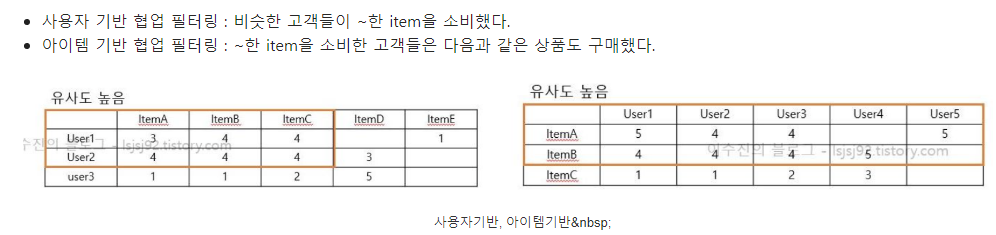

아이템기반 선정

### 데이터 불러오기, 전처리

위에서 기본적으로 전처리한 데이터를 필요한 칼럼만 불러와서 합친 뒤 진행

In [53]:
#conda install scikit-learn 

Note: you may need to restart the kernel to use updated packages.

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\HAIM\miniconda3\envs\habbu

  added / updated specs:
    - scikit-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    fftw-3.3.9                 |       h2bbff1b_1         672 KB
    icc_rt-2022.1.0            |       h6049295_2         6.5 MB
    joblib-1.1.1               |  py310haa95532_0         387 KB
    openssl-1.1.1s             |       h2bbff1b_0         5.5 MB
    scikit-learn-1.1.3         |  py310hd77b12b_0         6.3 MB
    scipy-1.9.3                |  py310h86744a3_0        18.0 MB
    threadpoolctl-2.2.0        |     pyh0d69192_0          16 KB
    ------------------------------------------------------------
                                           Total:        37.5 MB

The following NEW packages will be 

In [37]:
import pandas as pd
import pickle
import os
import ast

In [38]:
rating = pd.read_csv('./data/rate_Af_pre.csv')
wine = pd.read_csv('./data/wine_Af_pre.csv')

C:\Users\tjtmd\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [39]:
# rating, wineid
rating = rating[['User Rating','Wine ID','user_id']]
wine = wine[['Wine ID','Wine','Rating']]

In [40]:
# rating 데이터와 wine 데이터를 merge해서 하나로 합침
wine_rating = pd.merge(rating, wine, on="Wine ID")

In [41]:
wine_rating.head()

,User Rating,Wine ID,user_id,Wine,Rating
0,5.0,82025,2644975,Cabernet Sauvignon 2018,4.9
1,5.0,82025,2644975,Cabernet Sauvignon 2008,4.8
2,5.0,82025,2644975,Cabernet Sauvignon 2012,4.8
3,5.0,82025,2644975,Cabernet Sauvignon 2010,4.8
4,5.0,82025,2644975,Cabernet Sauvignon 2007,4.8


### 피봇 테이블 생성

아이템 기반 cf 적용을 위해 피봇 테이블 생성

In [42]:
# 피봇테이블 생성
wine_rating2 = wine_rating.pivot_table('User Rating', index = 'Wine', columns='user_id') # 아이템 기반 cf에 사용


rating_wine2 = wine_rating.pivot_table('User Rating', index = 'user_id', columns='Wine') # 사용자 기반 cf에 사용

In [43]:
wine_rating2.head()

user_id,0,48,97,135,140,159,251,293,1201,2698,...,60812557,60814728,60815329,60817282,60817983,60825787,60840162,60846266,60882838,60917111
Wine,,,,,,,,,,,,,,,,,,,,,
25 anni Montefalco Sagrantino 1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alexander Valley Cabernet Sauvignon 1999,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alexander Valley Cabernet Sauvignon 2000,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alexander Valley Cabernet Sauvignon 2016,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alexander Valley Cabernet Sauvignon 2017,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [190]:
# 피봇테이블의 nan 처리
wine_rating2.fillna(0, inplace = True)
wine_rating2.head()

user_id,0,48,97,135,140,159,251,293,1201,2698,...,60812557,60814728,60815329,60817282,60817983,60825787,60840162,60846266,60882838,60917111
Wine,,,,,,,,,,,,,,,,,,,,,
25 anni Montefalco Sagrantino 1997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alexander Valley Cabernet Sauvignon 1999,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alexander Valley Cabernet Sauvignon 2000,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alexander Valley Cabernet Sauvignon 2016,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alexander Valley Cabernet Sauvignon 2017,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 모델링

#### 유사도 추출
유사한 아이템끼리(평점이 비슷한) 추천을 해주기 위해 코사인 유사도를 계산

In [191]:
# 유사도값 추출(코사인유사도)
from sklearn.metrics.pairwise import cosine_similarity

similarity_rate = cosine_similarity(wine_rating2, wine_rating2)

In [192]:
print(similarity_rate)

[[1.         0.01743446 0.01743446 ... 0.02134544 0.02134544 0.00531971]
 [0.01743446 1.         1.         ... 0.01851556 0.01851556 0.0397567 ]
 [0.01743446 1.         1.         ... 0.01851556 0.01851556 0.0397567 ]
 ...
 [0.02134544 0.01851556 0.01851556 ... 1.         1.         0.00372309]
 [0.02134544 0.01851556 0.01851556 ... 1.         1.         0.00372309]
 [0.00531971 0.0397567  0.0397567  ... 0.00372309 0.00372309 1.        ]]


#### 유사도 값이 들어간 df 생성
위에서 계산한 코사인유사도 값을 인덱스와 칼럼에 와인을 넣어 df를 생성

In [193]:
similarity_rate_df = pd.DataFrame(
    data = similarity_rate,
    index = wine_rating2.index,
    columns=wine_rating2.index)

In [194]:
similarity_rate_df.head()

Wine,25 anni Montefalco Sagrantino 1997,Alexander Valley Cabernet Sauvignon 1999,Alexander Valley Cabernet Sauvignon 2000,Alexander Valley Cabernet Sauvignon 2016,Alexander Valley Cabernet Sauvignon 2017,Alter Ego de Château Palmer 2015,Altero Brunello di Montalcino 2015,Altero Brunello di Montalcino 2016,Amarone della Valpolicella Classico 1997,Amarone della Valpolicella Classico 2000,...,Échezeaux Grand Cru 2009,Échezeaux Grand Cru 2010,Échezeaux Grand Cru 2011,Échezeaux Grand Cru 2012,Échezeaux Grand Cru 2013,Échezeaux Grand Cru 2014,Échezeaux Grand Cru 2015,Échezeaux Grand Cru 2018,Échezeaux Grand Cru 2019,Élu 2014
Wine,,,,,,,,,,,,,,,,,,,,,
25 anni Montefalco Sagrantino 1997,1.000000,0.017434,0.017434,0.017434,0.017434,0.030129,0.028004,0.028004,0.033140,0.065763,...,0.021345,0.021345,0.021345,0.021345,0.021345,0.021345,0.021345,0.021345,0.021345,0.005320
Alexander Valley Cabernet Sauvignon 1999,0.017434,1.000000,1.000000,1.000000,1.000000,0.047301,0.022871,0.022871,0.041895,0.023728,...,0.018516,0.018516,0.018516,0.018516,0.018516,0.018516,0.018516,0.018516,0.018516,0.039757
Alexander Valley Cabernet Sauvignon 2000,0.017434,1.000000,1.000000,1.000000,1.000000,0.047301,0.022871,0.022871,0.041895,0.023728,...,0.018516,0.018516,0.018516,0.018516,0.018516,0.018516,0.018516,0.018516,0.018516,0.039757
Alexander Valley Cabernet Sauvignon 2016,0.017434,1.000000,1.000000,1.000000,1.000000,0.047301,0.022871,0.022871,0.041895,0.023728,...,0.018516,0.018516,0.018516,0.018516,0.018516,0.018516,0.018516,0.018516,0.018516,0.039757
Alexander Valley Cabernet Sauvignon 2017,0.017434,1.000000,1.000000,1.000000,1.000000,0.047301,0.022871,0.022871,0.041895,0.023728,...,0.018516,0.018516,0.018516,0.018516,0.018516,0.018516,0.018516,0.018516,0.018516,0.039757


#### 와인 추천 함수 생성
위에 만든 df에서 비슷한 와인을 찾아줄 함수 생성

In [195]:
# 가장 유사도가 높은 top 5
def recommand_wine(Wine):
    return similarity_rate_df[Wine].sort_values(ascending=False)[:5]

In [200]:
recommand_wine("Pauillac (Grand Cru Classé) 2015")

Wine
Pauillac (Grand Cru Classé) 2015    1.000000
Pauillac (Grand Cru Classé) 2016    0.913256
Pauillac (Grand Cru Classé) 2010    0.913256
Pauillac (Grand Cru Classé) 2009    0.913256
Pauillac (Grand Cru Classé) 2005    0.892297
Name: Pauillac (Grand Cru Classé) 2015, dtype: float64

연도만 바꿔서 마셔라 11~14는 15, 16과 기후가 많이 달랐나?

In [198]:
wine.tail()

,Wine ID,Wine,Rating
1769,6020,Pavillon Rouge du Château Margaux 2004,4.4
1770,1139286,Campo León Amarone della Valpolicella 2013,4.4
1771,79262,Pauillac (Grand Cru Classé) 2015,4.4
1772,89753,Valpolicella Superiore Monte Lodoletta 2010,4.4
1773,9958,Dominus (Christian Moueix) 2006,4.4


## 와인 cbf
cf ==> vivino 유저와 와인간의 rating(점수)을 이용해서 아이템|사용자끼리 유사도를 찾음.

cbf ==> 아이템|사용자끼리 유사도를 찾음x, 아이템의 추가 정보를 이용해 특정 선호 아이템과 유사 아이템을 추천해주는 방식.

위에서 전처리한 유저들이 해당와인을 마시며 느낀 것을 남긴 리뷰에서 가장 많이 언급된 푸드와 향정보가 있음.

### 데이터 불러오기, 전처리

In [47]:
import pandas as pd
import pickle
import os
import ast

In [48]:
rating = pd.read_csv('./data/rate_Af_pre.csv')
wine = pd.read_csv('./data/wine_Af_pre.csv')

C:\Users\tjtmd\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [49]:
wine.head(2)

,Winery,Year,Wine ID,Wine,Rating,num_review,image,name2,acidity,intensity,sweetness,tannin,user_structure_count,calculated_structure_count,flavor,description,food,url
0,Screaming Eagle,2018,82025,Cabernet Sauvignon 2018,4.9,44,//images.vivino.com/thumbs/Z92v0bohTBaVUVPNjiX...,cabernet-sauvignon,3.360757,4.567344,2.020631,3.533957,169,194,"['oak', 'black_fruit', 'non_oak', 'spices', 'e...",NaN,"['Beef', 'Lamb', 'Game (deer, venison)', 'Matu...",https://www.gilturners.com/wine/2018-screaming...
1,Schrader,2015,3151741,Cabernet Sauvignon CCS Beckstoffer To Kalon Vi...,4.9,33,//images.vivino.com/thumbs/_jt3dPPrSZKfVmV6J8Y...,cabernet-sauvignon-ccs-beckstoffer-to-kalon-vi...,3.334318,4.537772,1.820898,3.224029,98,72,"['black_fruit', 'oak', 'non_oak', 'spices', 'e...",NaN,"['Beef', 'Lamb', 'Game (deer, venison)', 'Matu...",https://tarzanawineandspirits.com/


In [50]:
wine=wine[['Wine', 'Rating', 'num_review', 'flavor', 'food']]  # 필요칼럼으로 정리
wine.head(5)

,Wine,Rating,num_review,flavor,food
0,Cabernet Sauvignon 2018,4.9,44,"['oak', 'black_fruit', 'non_oak', 'spices', 'e...","['Beef', 'Lamb', 'Game (deer, venison)', 'Matu..."
1,Cabernet Sauvignon CCS Beckstoffer To Kalon Vi...,4.9,33,"['black_fruit', 'oak', 'non_oak', 'spices', 'e...","['Beef', 'Lamb', 'Game (deer, venison)', 'Matu..."
2,Unico 2009,4.8,1955,"['oak', 'earth', 'non_oak', 'black_fruit', 'sp...","['Beef', 'Lamb', 'Game (deer, venison)']"
3,Grand Vin Pauillac (Premier Grand Cru Classé) ...,4.8,1319,"['oak', 'earth', 'non_oak', 'black_fruit', 'sp...","['Beef', 'Lamb', 'Game (deer, venison)', 'Poul..."
4,Château Margaux (Premier Grand Cru Classé) 2000,4.8,1265,"['oak', 'earth', 'black_fruit', 'non_oak', 'sp...","['Beef', 'Lamb', 'Game (deer, venison)', 'Poul..."


In [51]:
wine.shape

(1774, 5)

#### 새로운 평점 만들기

기존에 wine 리스트 자체가 3.0이상의 높은 점수를 받은 와인으로만 이루어져 있음.

뒤에 점수를 조금더 세분화하여 보는 것이 추천에 유리할 것이라고 생각 되기도 했고,

리뷰수와 평점을 고려하여 새로운 평점을 만들어내는 weight rating이라는 것이 있어 적용해봄.

weight rating 방식은 '리뷰수 * 기존점수/(리뷰수+분위수)' + '리뷰수 *기존점수평균/(리뷰수+분위수)'을 사용

In [52]:

m = wine['num_review'].quantile(0.9) #0.9분위수
print(m)
wine = wine.loc[wine['num_review'] >= m]

1353.7


In [53]:
wine.shape

(178, 5)

In [54]:
c = wine['Rating'].mean()
print(c)

4.5359550561797715


In [55]:
def weight_rating(x,m=m,c=c):
    v=x['num_review']
    r=x['Rating']
    
    return(v/(v+m)*r)+(m/(v+m)*c)

In [56]:
wine['score'] = wine.apply(weight_rating,axis=1)

In [57]:
wine.head()

,Wine,Rating,num_review,flavor,food,score
2,Unico 2009,4.8,1955,"['oak', 'earth', 'non_oak', 'black_fruit', 'sp...","['Beef', 'Lamb', 'Game (deer, venison)']",4.691970
70,Unico Reserva Especial Edición,4.7,12836,"['oak', 'non_oak', 'earth', 'black_fruit', 'sp...","['Beef', 'Lamb', 'Game (deer, venison)']",4.684350
71,Tignanello 2018,4.7,6562,"['oak', 'earth', 'black_fruit', 'non_oak', 're...","['Beef', 'Lamb', 'Veal', 'Poultry', 'Cured Meat']",4.671946
72,Valbuena 5º 2010,4.7,5356,"['oak', 'non_oak', 'earth', 'black_fruit', 'sp...","['Beef', 'Lamb', 'Game (deer, venison)']",4.666903
73,Sassicaia 2016,4.7,4933,"['oak', 'earth', 'black_fruit', 'non_oak', 're...","['Beef', 'Pasta', 'Lamb', 'Veal', 'Game (deer,...",4.664677


In [58]:
wine.shape

(178, 6)

#### 콘텐츠 기반 필터링을 위한 컬럼추출

In [59]:
wine[['flavor','food']].head()

,flavor,food
2,"['oak', 'earth', 'non_oak', 'black_fruit', 'sp...","['Beef', 'Lamb', 'Game (deer, venison)']"
70,"['oak', 'non_oak', 'earth', 'black_fruit', 'sp...","['Beef', 'Lamb', 'Game (deer, venison)']"
71,"['oak', 'earth', 'black_fruit', 'non_oak', 're...","['Beef', 'Lamb', 'Veal', 'Poultry', 'Cured Meat']"
72,"['oak', 'non_oak', 'earth', 'black_fruit', 'sp...","['Beef', 'Lamb', 'Game (deer, venison)']"
73,"['oak', 'earth', 'black_fruit', 'non_oak', 're...","['Beef', 'Pasta', 'Lamb', 'Veal', 'Game (deer,..."


In [60]:
wine['flavor']=wine['flavor'].apply(ast.literal_eval)
wine['food']=wine['food'].apply(ast.literal_eval)

In [61]:
' '.join(['oak', 'non_oak', 'black_fruit', 'spices', 'red_fruit'])

'oak non_oak black_fruit spices red_fruit'

In [62]:
wine[['flavor','food']].head()

,flavor,food
2,"[oak, earth, non_oak, black_fruit, spices, red...","[Beef, Lamb, Game (deer, venison)]"
70,"[oak, non_oak, earth, black_fruit, spices, red...","[Beef, Lamb, Game (deer, venison)]"
71,"[oak, earth, black_fruit, non_oak, red_fruit, ...","[Beef, Lamb, Veal, Poultry, Cured Meat]"
72,"[oak, non_oak, earth, black_fruit, spices, red...","[Beef, Lamb, Game (deer, venison)]"
73,"[oak, earth, black_fruit, non_oak, red_fruit, ...","[Beef, Pasta, Lamb, Veal, Game (deer, venison)]"


In [63]:
wine['flavor']=wine['flavor'].apply(lambda x: ''.join(x).replace(',','').replace("'",""))

In [64]:
wine.flavor = wine.flavor.apply(lambda x: x.replace('[','').replace(']', ''))

In [65]:
wine['food']=wine['food'].apply(lambda x: ''.join(x).replace(',','').replace("'",""))

In [66]:
wine.food = wine.food.apply(lambda x: x.replace('[','').replace(']', ''))

In [69]:
wine[['flavor','food']].head()

,flavor,food
2,oakearthnon_oakblack_fruitspicesred_fruitmicro...,BeefLambGame (deer venison)
70,oaknon_oakearthblack_fruitspicesred_fruitmicro...,BeefLambGame (deer venison)
71,oakearthblack_fruitnon_oakred_fruitspicesmicro...,BeefLambVealPoultryCured Meat
72,oaknon_oakearthblack_fruitspicesred_fruitmicro...,BeefLambGame (deer venison)
73,oakearthblack_fruitnon_oakred_fruitspicesmicro...,BeefPastaLambVealGame (deer venison)


### 모델링

#### 향 벡터화

In [70]:
from sklearn.feature_extraction.text import CountVectorizer

In [71]:
counter_vector = CountVectorizer(ngram_range=(1,3))

In [72]:
c_vector_flavor = counter_vector.fit_transform(wine['flavor'])

In [73]:
c_vector_flavor.shape

(178, 48)

In [74]:
c_vector_flavor

<178x48 sparse matrix of type '<class 'numpy.int64'>'
	with 178 stored elements in Compressed Sparse Row format>

#### 푸드 벡터화

In [75]:
counter_vector = CountVectorizer(ngram_range=(1,3))

In [76]:
c_vector_food = counter_vector.fit_transform(wine['food'])

In [77]:
c_vector_food.shape

(178, 39)

In [78]:
c_vector_food

<178x39 sparse matrix of type '<class 'numpy.int64'>'
	with 1368 stored elements in Compressed Sparse Row format>

#### 유사도 값 추출(코사인유사도)

In [154]:
# 향
from sklearn.metrics.pairwise import cosine_similarity

similarity_flavor = cosine_similarity(c_vector_flavor, c_vector_flavor).argsort()[:,::-1]
print(similarity_flavor)

[[  0   6   7 ... 113 112  88]
 [  1 177  55 ... 114 113   0]
 [ 88  35  85 ... 114 113   0]
 ...
 [102 161 120 ... 106 105   0]
 [102 161 120 ... 106 105   0]
 [177  74  53 ... 108 107   0]]


In [81]:
# 푸드
from sklearn.metrics.pairwise import cosine_similarity

similarity_food = cosine_similarity(c_vector_food, c_vector_food).argsort()[:,::-1]
print(similarity_food)

[[  0  11  62 ...  85  86  88]
 [  0  11  62 ...  85  86  88]
 [ 88  15  84 ... 113 112   0]
 ...
 [177 107  96 ... 117 119  88]
 [177 107  96 ... 117 119  88]
 [177 107  96 ... 117 119  88]]


#### 와인 추천 사용자 함수 생성
flavor, food 맛 기반의 유사도를 기준으로 와인 추천

In [156]:
# 향
def recommend_wine_list_by_flavor(df,Wine,top=10):
    # 특정 와인 정보 추출
    target_wine_index = df[df['Wine'] == Wine].index.values
    
    # 타겟 와인과 비슷한 코사인 유사도 값
    sim_index = similarity_flavor[target_wine_index,:top].reshape(-1)
    
    # 본인 제외
    sim_index = sim_index[sim_index!=target_wine_index]
    
    # 추천 결과 새로운 df 생성, rating으로 정렬
    result = df.iloc[sim_index].sort_values('Rating', ascending = False)[:10]
    
    return result
# 푸드
def recommend_wine_list_by_food(df,Wine,top=10):
    # 특정 와인 정보 추출
    target_wine_index = df[df['Wine'] == Wine].index.values
    
    # 타겟 와인과 비슷한 코사인 유사도 값
    sim_index = similarity_food[target_wine_index,:top].reshape(-1)
    
    # 본인 제외
    sim_index = sim_index[sim_index!=target_wine_index]
    
    # 추천 결과 새로운 df 생성, rating으로 정렬
    result = df.iloc[sim_index].sort_values('Rating', ascending = False)[:10]
    
    return result

### 결과 보기
향 으로 추천한 결과를 띄워놨는데 상위 향들이 같은 것을 볼 있음. 

같은 종류의 향을 느낄 수 있는 와인들 중 스코어가 높은 순으로 와인 확인 가능

In [159]:
wine[0:1]

,Wine,Rating,num_review,flavor,food,score
2,Unico 2009,4.8,1955,oakearthnon_oakblack_fruitspicesred_fruitmicro...,BeefLambGame (deer venison),4.69197


In [160]:
recommend_wine_list_by_flavor(wine,Wine='Unico 2009')

,Wine,Rating,num_review,flavor,food,score
388,Tignanello 2016,4.6,13097,oakearthblack_fruitnon_oakred_fruitspicesmicro...,BeefLambVealPoultryCured Meat,4.594000
426,Tignanello 2019,4.6,1676,oakearthblack_fruitnon_oakred_fruitspicesmicro...,BeefLambVealPoultryCured Meat,4.571384
390,Tignanello 2017,4.6,7941,oakearthblack_fruitnon_oakred_fruitspicesmicro...,BeefLambVealPoultryCured Meat,4.590672
965,Tignanello 2009,4.5,6922,oakearthblack_fruitnon_oakred_fruitspicesmicro...,BeefLambVealPoultryCured Meat,4.505881
962,Tignanello 2011,4.5,9663,oakearthblack_fruitnon_oakred_fruitspicesmicro...,BeefLambVealPoultryCured Meat,4.504418
961,Tignanello 2012,4.5,10896,oakearthblack_fruitnon_oakred_fruitspicesmicro...,BeefLambVealPoultryCured Meat,4.503973
960,Tignanello 2013,4.5,11321,oakearthblack_fruitnon_oakred_fruitspicesmicro...,BeefLambVealPoultryCured Meat,4.503840
959,Tignanello 2014,4.5,13080,oakearthblack_fruitnon_oakred_fruitspicesmicro...,BeefLambVealPoultryCured Meat,4.503372
988,Tignanello 2001,4.5,1804,oakearthblack_fruitnon_oakred_fruitspicesmicro...,BeefLambVealPoultryCured Meat,4.515414
994,Tignanello 2000,4.5,1479,oakearthblack_fruitnon_oakred_fruitspicesmicro...,BeefLambVealPoultryCured Meat,4.517182


In [161]:
wine.head(3)

,Wine,Rating,num_review,flavor,food,score
2,Unico 2009,4.8,1955,oakearthnon_oakblack_fruitspicesred_fruitmicro...,BeefLambGame (deer venison),4.691970
70,Unico Reserva Especial Edición,4.7,12836,oaknon_oakearthblack_fruitspicesred_fruitmicro...,BeefLambGame (deer venison),4.684350
71,Tignanello 2018,4.7,6562,oakearthblack_fruitnon_oakred_fruitspicesmicro...,BeefLambVealPoultryCured Meat,4.671946


## 와인 lfcf
cf ==> vivino 유저와 와인간의 rating(점수)을 이용해서 아이템|사용자끼리 유사도를 찾음.

cbf ==> 아이템|사용자끼리 유사도를 찾음x, 아이템의 추가 정보를 이용해 특정 선호 아이템과 유사 아이템을 추천해주는 방식.

lfcf(latent factor collaborate filtering) ==> cf에서 플러스 알파를 한 개념.

SVD 등을 통해 행렬분해를 진행하여 잠재요인을 찾아내고, 그 잠재요인의 값을 통해 매겨 평가하지 않은 콘텐츠의 점수를 예측하는 것이 포인트.

우리는 cf에서 만들었던 피봇테이블을 특이값 분해를 통해 분해함으로서 어떠한 요소의 값을 갖게 만들고, 이 값을 피어슨 상관계수를 통해 유사도를 구한다음 랭크처리하여 결과를 도출하였음.

### cf와 같은 부분

In [2]:
import pandas as pd
import pickle
import os
import ast

In [ ]:
# 잠재요인 협업 필터링(latent factor collaborative filtering)

In [162]:
# 데이터 준비
rating = pd.read_csv('./data/rate_Af_pre.csv')
wine = pd.read_csv('./data/wine_Af_pre.csv')

In [163]:
rating.head(3)

,Year,Wine ID,User Rating,Note,CreatedAt,user_id,double
0,2018.0,82025,5.0,"What can you say? Really, really, good. So sm...",2021-06-13T00:57:55.000Z,2644975,82025-2018.0-2644975
1,2018.0,82025,4.5,Wally’s has Screaming Eagle ‘18 by the glass f...,2021-10-26T04:40:45.000Z,52282875,82025-2018.0-52282875
2,2018.0,82025,5.0,Most incredible wine experience of my life…,2022-03-19T04:35:28.000Z,2575166,82025-2018.0-2575166


In [164]:
wine.head(3)

,Winery,Year,Wine ID,Wine,Rating,num_review,image,name2,acidity,intensity,sweetness,tannin,user_structure_count,calculated_structure_count,flavor,description,food,url
0,Screaming Eagle,2018,82025,Cabernet Sauvignon 2018,4.9,44,//images.vivino.com/thumbs/Z92v0bohTBaVUVPNjiX...,cabernet-sauvignon,3.360757,4.567344,2.020631,3.533957,169,194,"['oak', 'black_fruit', 'non_oak', 'spices', 'e...",NaN,"['Beef', 'Lamb', 'Game (deer, venison)', 'Matu...",https://www.gilturners.com/wine/2018-screaming...
1,Schrader,2015,3151741,Cabernet Sauvignon CCS Beckstoffer To Kalon Vi...,4.9,33,//images.vivino.com/thumbs/_jt3dPPrSZKfVmV6J8Y...,cabernet-sauvignon-ccs-beckstoffer-to-kalon-vi...,3.334318,4.537772,1.820898,3.224029,98,72,"['black_fruit', 'oak', 'non_oak', 'spices', 'e...",NaN,"['Beef', 'Lamb', 'Game (deer, venison)', 'Matu...",https://tarzanawineandspirits.com/
2,Vega Sicilia,2009,77137,Unico 2009,4.8,1955,//images.vivino.com/thumbs/SCnpJk_ySUe6XS3U-lF...,unico,3.700484,3.837726,1.783766,3.415408,2343,1509,"['oak', 'earth', 'non_oak', 'black_fruit', 'sp...","Rioja may be the most famous region in Spain, ...","['Beef', 'Lamb', 'Game (deer, venison)']",https://winecellarage.com/wine/2009-vega-sicil...


In [165]:
# 데이터 전처리
# 필요 없는 컬럼 삭제
rating = rating[['Wine ID','User Rating','user_id']]
wine = wine[['Wine ID', 'Wine']]

In [166]:
# rating 데이터와 wine 데이터를 merge해서 하나로 합침
wine_data = pd.merge(rating,wine,on="Wine ID")
wine_data.head()

,Wine ID,User Rating,user_id,Wine
0,82025,5.0,2644975,Cabernet Sauvignon 2018
1,82025,5.0,2644975,Cabernet Sauvignon 2008
2,82025,5.0,2644975,Cabernet Sauvignon 2012
3,82025,5.0,2644975,Cabernet Sauvignon 2010
4,82025,5.0,2644975,Cabernet Sauvignon 2007


In [167]:
wine_data.shape

(11699553, 4)

In [168]:
# 피봇테이블 생성
wine_pivot = wine_data.pivot_table('User Rating', index = 'user_id', columns='Wine')
wine_pivot.head(3)

Wine,25 anni Montefalco Sagrantino 1997,Alexander Valley Cabernet Sauvignon 1999,Alexander Valley Cabernet Sauvignon 2000,Alexander Valley Cabernet Sauvignon 2016,Alexander Valley Cabernet Sauvignon 2017,Alter Ego de Château Palmer 2015,Altero Brunello di Montalcino 2015,Altero Brunello di Montalcino 2016,Amarone della Valpolicella Classico 1997,Amarone della Valpolicella Classico 2000,...,Échezeaux Grand Cru 2009,Échezeaux Grand Cru 2010,Échezeaux Grand Cru 2011,Échezeaux Grand Cru 2012,Échezeaux Grand Cru 2013,Échezeaux Grand Cru 2014,Échezeaux Grand Cru 2015,Échezeaux Grand Cru 2018,Échezeaux Grand Cru 2019,Élu 2014
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,NaN,4.5,4.5,4.5,4.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [169]:
# 피봇테이블의 nan처리
wine_pivot = wine_pivot.fillna(0)
wine_pivot.head(3)

Wine,25 anni Montefalco Sagrantino 1997,Alexander Valley Cabernet Sauvignon 1999,Alexander Valley Cabernet Sauvignon 2000,Alexander Valley Cabernet Sauvignon 2016,Alexander Valley Cabernet Sauvignon 2017,Alter Ego de Château Palmer 2015,Altero Brunello di Montalcino 2015,Altero Brunello di Montalcino 2016,Amarone della Valpolicella Classico 1997,Amarone della Valpolicella Classico 2000,...,Échezeaux Grand Cru 2009,Échezeaux Grand Cru 2010,Échezeaux Grand Cru 2011,Échezeaux Grand Cru 2012,Échezeaux Grand Cru 2013,Échezeaux Grand Cru 2014,Échezeaux Grand Cru 2015,Échezeaux Grand Cru 2018,Échezeaux Grand Cru 2019,Élu 2014
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,4.5,4.5,4.5,4.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [170]:
# 피봇테이블 전치
wine_pivot2 = wine_pivot.values.T
wine_pivot2.shape

(1216, 153630)

### cf와 다른 부분

#### SVD

In [171]:
# SVD(특이값 분해) :  행렬을 대각화하는 한 방법
from sklearn.decomposition import TruncatedSVD

SVD = TruncatedSVD(n_components=12)
matrix = SVD.fit_transform(wine_pivot2)


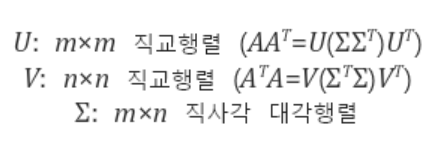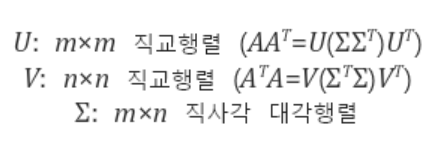

In [172]:
matrix.shape

(1216, 12)

In [173]:
matrix[0]

array([ 9.63525904, -3.83309984, -1.84501013,  0.31887632,  0.72581391,
       -0.25443488,  0.17301898,  1.18916082,  3.1218116 ,  0.18953893,
        2.51271661,  0.22542903])

#### 피어슨 상관계수

상관관계를 알아보기 위해 히트맵 그려 보았음 

In [174]:
# 피어슨 상관계수 값
import numpy as np
corr = np.corrcoef(matrix)
corr.shape

(1216, 1216)

<AxesSubplot:>

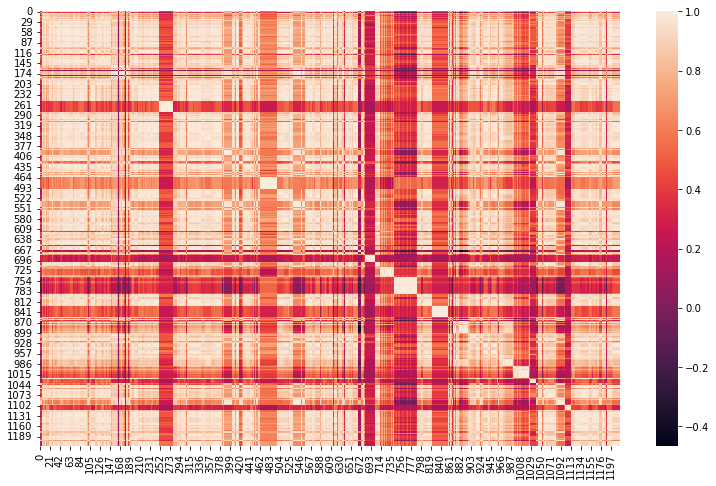

In [175]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(13,8))
sns.heatmap(corr)

#### 함수선언

In [176]:
# 와인 추천 사용자 함수 생성
# 상관계수 값이 0.9 이상인 와인 추천
wine_title = wine_pivot.columns
wine_list = list(wine_title)

In [178]:
def recommand_wine(Wine):
    target = wine_list.index(Wine)
    corr_target = corr[target] # 상관계수값
    result = list(wine_title[(corr_target>=0.9)])[:5]
    
    return result

### 결과보기


In [180]:
recommand_wine("Unico 2009")

['25 anni Montefalco Sagrantino 1997',
 'Alter Ego de Château Palmer 2015',
 'Altero Brunello di Montalcino 2015',
 'Altero Brunello di Montalcino 2016',
 'Amarone della Valpolicella Classico 2000']

## 한계점
cf모델을 적용하였을 때 유사도가 낮은 와인도 있었음

리뷰를 크롤링 해왔지만 사용하지 못하였음 (양이 너무 많아서 단어 토큰화 하기 어려웠음)